In [1]:
import json
import logging
import sys
import os
import math
import shutil
from pathlib import Path
from itertools import chain
# from megatron.data.dataset_utils import get_indexed_dataset_

# import horovod.torch as hvd
# from dotenv import load_dotenv
import torch
import numpy as np
import datasets
from torch.utils.data import DataLoader, DistributedSampler
from datasets import Dataset, load_dataset
from huggingface_hub import hf_hub_download
from sklearn.metrics import f1_score, accuracy_score

sys.path.append('../')
# from lm_experiments_tools import TrainerArgs
from lm_experiments_tools.trainer import Trainer

from torch.nn.utils.rnn import pad_sequence
# from lm_experiments_tools.lm_datasets import get_lm_datasets
from task_utils.contract_nli import process_file
import transformers  # noqa: E402
from transformers import AutoConfig, AutoTokenizer, HfArgumentParser  # noqa: E402

from lm_experiments_tools.utils import collect_run_configuration, get_cls_by_name, get_optimizer  # noqa: E402
import lm_experiments_tools.optimizers as optimizers  # noqa: E402



libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [2]:

# load_dotenv()

# logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
#                     level=logging.INFO)
# logger = logging.getLogger(__name__)

# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# # if CUDA_VISIBLE_DEVICES is not set make all gpus visible
# if os.environ.get('CUDA_VISIBLE_DEVICES', None) is None:
#     os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in range(torch.cuda.device_count())])

# logger.info(f"CUDA_VISIBLE_DEVICES: {os.environ['CUDA_VISIBLE_DEVICES']}")
# # first call to torch.cuda.device_count() sets visible gpus, following calls will not change the result
# logger.info(f"CUDA DEVICE COUNT: {torch.cuda.device_count()}")

# hvd.init()


# # limit # of CPU threads to be used per pytorch worker, otherwise it might use all cpus and throttle gpus
# # > 2 fails cause of https://github.com/pytorch/pytorch/issues/56615
# # need to upgrade to torch>1.8.1
# torch.set_num_threads(4)
# # all gpus set with CUDA_VISIBLE_DEVICES are visible to process, indexing from 0 to ...
# torch.cuda.set_device(hvd.local_rank())

# parser = HfArgumentParser(TrainerArgs)
# parser.add_argument('--task_name', type=str, help="Task name, wikitext, ...")
# parser.add_argument('--validate_only', action='store_true', default=False,
#                     help='Skip training and run only validation. (default: False)')
# parser.add_argument('--working_dir', type=str, default='.',
#                     help='working dir, should be a dir with t5-experiments repo (default: .)')
# parser.add_argument('--seed', type=int, default=42, help='random seed')
# parser.add_argument('--show_valid_examples', type=int, default=0,
#                     help='how many valid examples to show during training (default: 0)')
# parser.add_argument('--input_seq_len', type=int, default=128, help='input sequnce length (default: 128).')
# parser.add_argument('--target_seq_len', type=int, default=16, help='target sequnce length, should be set to '
#                                                                    'max(len(target))+1 for EOS (default: 16).')
# parser.add_argument('--data_n_workers', type=int, default=2, help='number of dataloader workers (default: 2)')

# parser.add_argument('--input_prefix', type=str, default='', help='add task prefix to an input string (default: "")')
# parser.add_argument('--sliding_window', action='store_true', help='use slinding window attentinon mask, '
#                     'eval on last segment only', default=False)

# # model args
# parser.add_argument('--from_pretrained', type=str, help='model name in HF Model Hub (default: "")')
# parser.add_argument('--model_cfg', type=str, help='path to model configuration file (default: "")')
# parser.add_argument('--model_cls', type=str, default='transformers:BertForPreTraining',
#                     help='model class name to use (default: transformers:BertForPreTraining)')
# parser.add_argument('--memory_cell_cls', type=str, default=None, help='cell class for RMT')
# parser.add_argument('--recurrent_wrapper_cls', type=str, default=None, help='recurrent wrapper class for RMT')
# parser.add_argument('--model_cpt', type=str, default=None, help='pretrained model checkpoint path')
# parser.add_argument('--backbone_cls', type=str, default=None,
#                     help='backbone class name to use for RMT')
# parser.add_argument('--model_type', type=str, default='encoder-decoder',
#                     help='model type, encoder, encoder-decoder, decoder, affects preprocessing '
#                          '(default: encoder-decoder)')


# # Aydar # RMT args 
# parser.add_argument('--input_size', type=int, default=None, help='maximal input size of the backbone model')
# parser.add_argument('--num_mem_tokens', type=int, default=None, help='number of memory tokens.')
# parser.add_argument('--max_n_segments', type=int, default=1, help='maximal segment number')
# # parser.add_argument('--sum_loss', action='store_true', default=False,
# #                     help='with this flag task loss from all segments is summed')
# # parser.add_argument('--bptt_depth', type=int, default=-1, help='max number of previous segments in gradient computation.')
# # parser.add_argument('--segment_ordering', type=str, help='segment order', default='regular',
# #                     choices=['regular', 'reversed', 'bidirectional', 'repeat_first', 'last_memory_only'])
# # parser.add_argument('--memory_forward_func', type=str, help='path to memory forward funсtion script', default=None)
# # parser.add_argument('--memory_layers', type=str, help='memory-augmented layer inds or "all" for all layers', default=None)
# # parser.add_argument('--share_memory_layers', action='store_true', help='share weights of memory layers', default=False)
# # parser.add_argument('--reconstruction_loss_coef', type=float, default=None,
# #                     help='reconstuction loss ratio in total loss')
# # # parser.add_argument('--segment_ordering', type=str,help='????', default='regular',
# # #                     choices=['regular', 'reversed', 'bidirectional', 'repeat_first', 'last_memory_only'])
# # parser.add_argument('--retain_graph', action='store_true', help='Retain computation graph during backward pass', default=False)
# # parser.add_argument('--use_truncated_backward', action='store_true', default=False,
# #                     help='whether to use RMT truncated bptt method in backward')
# # parser.add_argument('--k1', type=int, default=-1, help='(not implemented) If not -1, gradient update is done each k1 segments')
# parser.add_argument('--k2', type=int, default=-1, help='number of last segments used by backward')
# parser.add_argument('--freeze_model_weights', action='store_true', default=False,
#                     help='Stop training all model weights except memory layers')
# parser.add_argument('--backbone_cpt', type=str, default=None, help='backbone model checkpoint path')


# # tokenizer
# # todo: add wordpiece tokenizers support?
# parser.add_argument('--tokenizer', type=str, default=None, help='path or name of pre-trained HF Tokenizer')

# # optimizer args
# parser.add_argument('--optimizer', type=str, default='AdamW', help='optimizer name: AdamW, Adafactor. (default: AdamW)')
# parser.add_argument('--weight_decay', type=float, default=0.0, help='optimizer weight decay (default: 0.0)')
# parser.add_argument('--scale_parameter', action='store_true', default=False,
#                     help='Adafactor scale_parameter (default: False)')
# parser.add_argument('--relative_step', action='store_true', default=False,
#                     help='Adafactor relative_step (default: False)')
# parser.add_argument('--warmup_init', action='store_true', default=False,
#                     help='Adafactor warmup_init (default: False)')

In [3]:

def download_metric():
    scrolls_metric_path = hf_hub_download(repo_id="tau/scrolls", filename="metrics/scrolls.py", repo_type="dataset")
    updated_scrolls_metric_path = (
        os.path.dirname(scrolls_metric_path) + os.path.basename(scrolls_metric_path).replace(".", "_") + ".py"
    )
    shutil.copy(scrolls_metric_path, updated_scrolls_metric_path)
    return updated_scrolls_metric_path


scrolls_metric_path = download_metric()

task_to_metric = {
    'gov_report': ['rouge/rouge1', 'rouge/rouge2', 'rouge/rougeL', 'rouge/rougeLsum', 'rouge/geometric_mean'],
    'summ_screen_fd': ['rouge/rouge1', 'rouge/rouge2', 'rouge/rougeL', 'rouge/rougeLsum', 'rouge/geometric_mean'],
    'qmsum': ['rouge/rouge1', 'rouge/rouge2', 'rouge/rougeL', 'rouge/rougeLsum', 'rouge/geometric_mean'],
    'narrative_qa': ['f1'],
    'qasper': ['f1'],
    'quality': ['exact_match'],
    'contract_nli': ['exact_match']
}

tasks_with_duplicates = {'narrative_qa', 'qasper'}


# https://github.com/tau-nlp/scrolls/blob/5bfb8dbaf3a0128ac8c65922096fd95a645f6ba2/baselines/src/utils/duplicates.py#L1
# some tasks have multiple possible labels for single input, drop_duplicates_in_input will collect such labels
def drop_duplicates_in_input(untokenized_dataset):
    indices_to_keep = []
    id_to_idx = {}
    outputs = []
    for i, (id_, output) in enumerate(zip(untokenized_dataset["id"], untokenized_dataset["output"])):
        if id_ in id_to_idx:
            outputs[id_to_idx[id_]].append(output)
            continue
        indices_to_keep.append(i)
        id_to_idx[id_] = len(outputs)
        outputs.append([output])
    untokenized_dataset = untokenized_dataset.select(indices_to_keep).flatten_indices()
    untokenized_dataset = untokenized_dataset.remove_columns("output")
    untokenized_dataset = untokenized_dataset.add_column("outputs", outputs)
    return untokenized_dataset

In [4]:
class Holder:
    def __init__(self):
        pass
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return None

args = Holder()

In [5]:
# model_cpt = '/cephfs/home/bulatov/bulatov/RMT_light/runs/contract_nli/gpt2/linear_adamw_wd1e-03_124-128-1x128_mem2_bs128_regular_bptt-1_from_cpt_0-1/run_1/'
# model_cpt = "/cephfs/home/bulatov/bulatov/RMT_light/runs/contract_nli/gpt2/linear_adamw_wd1e-03_118-128-1x128_mem5_bs128_regular_bptt-1_from_cpt_0-1/run_1"
# model_cpt = '/cephfs/home/bulatov/bulatov/RMT_light/runs/contract_nli/gpt2/lr5e-05_linear_adamw_wd1e-03_236-128-2x128_mem5_bs128_iters1500_regular_bptt-2/run_1'

In [6]:
# import json
# with open(model_cpt + '/config.json', 'r') as f:
#     config = json.load(f)

# config

In [7]:
attrs = ("--model_path", "/home/jovyan/rmt/runs/test/scrolls",
"--from_pretrained", "gpt2",
"--task_name", "qasper",
"--model_type", "decoder",
"--memory_cell_cls", "modeling_rmt.language_modeling:MemoryCell",
"--recurrent_wrapper_cls", "modeling_rmt.language_modeling:RecurrentWrapper",
"--model_cls",  "transformers:AutoModelForCausalLM",
"--segment_alignment", "right",
# "--model_cpt", model_cpt,
"--optimizer", "AdamW",
"--weight_decay", "0.001",
"--lr", "1e-03", 
"--lr_scheduler", "constant_with_warmup",
"--clip_grad_value", "5.0")

int_attrs = (
    
# "--input_seq_len", "118",
"--input_seq_len", "248",
"--input_size", "128",
"--target_seq_len", "128",
"--num_mem_tokens", "2",
"--max_n_segments" ,"2", 
"--batch_size", "2", 
"--gradient_accumulation_steps", "1",
"--iters", "100",
"--num_warmup_steps", "100",
"--data_n_workers", "2",
"--log_interval", "10",
"--show_valid_examples", "5",
"--early_stopping_patience", "15",
"--seed", "42",
"--k2", "-1",)

In [8]:
for a, v in zip(int_attrs[::2], int_attrs[1::2]):
    setattr(args, a.split('--')[1], int(v))

for a, v in zip(attrs[::2], attrs[1::2]):
    try:
        setattr(args, a.split('--')[1], float(v))
    except ValueError:
        setattr(args, a.split('--')[1], v)

In [9]:

# args = parser.parse_args()
# set current working dir
# args.working_dir = str(Path(args.working_dir).expanduser().absolute())
# os.chdir(args.working_dir)
# if hvd.rank() == 0:
#     logger.info(f'hvd size: {hvd.size()}')
#     logger.info(f'FP16: {args.fp16}')

# if hvd.rank() == 0 and args.model_path is None:
#     logger.warning('model_path is not set: config, logs and checkpoints will not be saved.')

# # create model path and save configuration
# if hvd.rank() == 0 and args.model_path is not None:
#     model_path = Path(args.model_path)
#     if not model_path.exists():
#         Path(model_path).mkdir(parents=True)
#     args_dict = collect_run_configuration(args)
#     # todo: if model path exists and there is config file, write new config file aside
#     json.dump(args_dict, open(model_path/'config.json', 'w'), indent=4)

if not args.from_pretrained:
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer)
else:
    tokenizer = AutoTokenizer.from_pretrained(args.from_pretrained)


In [10]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
if args.model_type == 'decoder':
    from torch.nn.utils.rnn import pad_sequence
    # tokenizer.pad_token = tokenizer.eos_token
    # tokenizer.pad_token_id = tokenizer.eos_token
    tokenizer.add_special_tokens({'additional_special_tokens': ['[GEN]', '[PAD]']})
    gen_token = tokenizer.encode('[GEN]')[0]
    tokenizer.pad_token_id = tokenizer.encode('[PAD]')[0]
    id_pad_value = tokenizer.pad_token_id

    block_size = args.input_size
    if args.num_mem_tokens not in {0, None}:
        block_size -= 2 * args.num_mem_tokens

    def collate_fn(batch):
        inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
        if 'outputs' in batch[0]:
            # if we have more than 1 label per example (only in valid) take only one of them
            # to compute loss on valid
            target_text = [b['outputs'][0][:args.input_seq_len * 10] for b in batch]
        else:
            target_text = [b['output'][:args.input_seq_len * 10] for b in batch]

        collated = {}
        inputs = tokenizer.batch_encode_plus(list(inputs), max_length=args.input_seq_len, truncation=True, padding=False)
        labels = tokenizer.batch_encode_plus(list(target_text), padding=False)

        full_inputs = [torch.tensor(i[:args.input_seq_len - len(l) - 2] + [gen_token] + l + [eos_token]) for i, l in zip(inputs['input_ids'], labels['input_ids'])]
        labels_mask = [torch.zeros_like(i).bool() for i in full_inputs]
        for i, l in enumerate(labels['input_ids']):
            labels_mask[i][-len(l) - 2:] = True

        full_inputs = pad_sequence(full_inputs, padding_value=tokenizer.pad_token_id).T
        labels_mask = pad_sequence(labels_mask, padding_value=False).T

        gen_inputs = [torch.tensor(i[:args.input_seq_len - len(l) - 2] + [gen_token]) for i, l in zip(inputs['input_ids'], labels['input_ids'])]
        gen_inputs = pad_sequence(gen_inputs, padding_value=tokenizer.pad_token_id).T
        
        # labels_mask = torch.zeros_like(full_inputs).bool()
        

        collated['input_ids'] = collated['labels'] = full_inputs
        collated['input_ids_generate'] = gen_inputs
        collated['labels_mask'] = labels_mask
        collated['attention_mask'] = (full_inputs != id_pad_value).bool()
        collated['attention_mask_generate'] = (gen_inputs != id_pad_value).bool()

        collated['id'] = [b['id'] for b in batch]
        collated['target_text'] = target_text
        # for k, v in collated.items():
        #     if hasattr(v, 'shape'):
        #             print(k, v.shape)
        return collated

In [11]:

# get train dataset
# if hvd.rank() == 0:
#     logger.info(f'preparing dataset for: {args.task_name}')
dataset = datasets.load_dataset('tau/scrolls', args.task_name)
train_dataset = dataset['train']
valid_dataset = dataset['validation']
# shuffle train data each epoch (one loop over train_dataset)
# train_sampler = DistributedSampler(train_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=True,
#                                     drop_last=False, seed=args.seed)
per_worker_batch_size = int(args.batch_size * args.gradient_accumulation_steps)
global_batch_size = int(args.batch_size)
kwargs = {'pin_memory': True, 'num_workers': args.data_n_workers}
train_dataloader = DataLoader(train_dataset, batch_size=per_worker_batch_size, 
# sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)
                                # collate_fn=collate_train, **kwargs)
# get validation dataset
valid_dataloader = None
# if hvd.rank() == 0:
#     logger.info(f'preparing validation data from: {args.task_name}')
# valid_sampler = DistributedSampler(valid_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=per_worker_batch_size, 
# sampler=valid_sampler,
                                collate_fn=collate_fn, **kwargs)
                                # collate_fn=collate_valid, **kwargs)

# test_sampler = DistributedSampler(test_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=per_worker_batch_size, 
# sampler=test_sampler,
                                # collate_fn=collate_fn, **kwargs)
# if args.valid_interval is None:
#     args.valid_interval = args.log_interval


In [55]:
bs = 24
batch = [train_dataset[i] for i in range(bs)]

eos_token = tokenizer.eos_token_id
q_tok = tokenizer.encode('Question: ')
c_tok = tokenizer.encode('\nContext: ')
a_tok = tokenizer.encode('\nAnswer: ')
n_new_tokens = len(q_tok) + len(c_tok) + len(q_tok) + len(a_tok) + 1

inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
questions = [i[:i.index('\n\n')] for i in inputs]
contexts = [i[i.index('\n\n') + 2:] for i in inputs]

if 'outputs' in batch[0]:
    # if we have more than 1 label per example (only in valid) take only one of them
    # to compute loss on valid
    target_text = [b['outputs'][0][:args.input_seq_len * 10] for b in batch]
else:
    target_text = [b['output'][:args.input_seq_len * 10] for b in batch]

collated = {}
questions = tokenizer.batch_encode_plus(questions, max_length=args.input_seq_len, truncation=True, padding=False)['input_ids']
contexts = tokenizer.batch_encode_plus(contexts, max_length=args.input_seq_len, truncation=True, padding=False)['input_ids']
labels = tokenizer.batch_encode_plus(target_text, max_length=args.target_seq_len, truncation=True, padding=False)['input_ids']

full_inputs = [q_tok + q + c_tok + c[:args.input_seq_len - 2*len(q) - len(a) - n_new_tokens] + \
                q_tok + q + a_tok + a + [eos_token] for q, c, a in zip(questions, contexts, labels)]
full_inputs = [torch.tensor(i) for i in full_inputs]
labels_mask = [torch.zeros_like(i).bool() for i in full_inputs]

for i, l in enumerate(labels):
    labels_mask[i][-len(l) - 2:] = True

full_inputs = pad_sequence(full_inputs, padding_value=tokenizer.pad_token_id).T
labels_mask = pad_sequence(labels_mask, padding_value=False).T

gen_inputs = [q_tok + q + c_tok + c[:args.input_seq_len - 2*len(q) - len(a) - n_new_tokens] + \
                    q_tok + q + a_tok for q, c, a in zip(questions, contexts, labels)]
gen_inputs = [torch.tensor(i) for i in gen_inputs]
gen_inputs = pad_sequence(gen_inputs, padding_value=tokenizer.pad_token_id).T

collated['input_ids'] = collated['labels'] = full_inputs
collated['input_ids_generate'] = gen_inputs
collated['labels_mask'] = labels_mask
collated['attention_mask'] = (full_inputs != id_pad_value).bool()
collated['attention_mask_generate'] = (gen_inputs != id_pad_value).bool()

collated['id'] = [b['id'] for b in batch]
collated['target_text'] = target_text


In [56]:
args.input_size, args.input_seq_len, args.max_n_segments

(128, 248, 2)

In [57]:
block_size = args.input_seq_len // args.max_n_segments
context_size = block_size - len(q_tok + q + c_tok)

In [8]:
x, y = [1], [2]
ll = [x, y]
ll.append(ll[0])
ll

[[1], [2], [1]]

In [10]:
ll[-1].append(2)
ll

[[1], [2], [3, 2]]

In [58]:
q = questions[0]
c = contexts[0]
a = labels[0]

In [61]:
block_size - len(q_tok + q + c_tok)

110

In [62]:
# def get_sample(q, c, a):
context_size = block_size - len(q_tok + q + c_tok)
split_inds = list(range(0, len(c), context_size)) + [len(c)]
split_inds

[0, 110, 220, 248]

In [63]:
q = questions[0]
c = contexts[0]
a = labels[0]

In [91]:
args.segment_ordering = 'bidirectional'
args.segment_ordering = 'regular'

In [97]:
segments = [1, 2]
segments + segments[::-1][1:]

[1, 2, 1]

In [106]:
def get_sample(q, c, a):
    segments = [q_tok + q + c_tok + c[context_size * seg_num:context_size * (seg_num + 1)] for seg_num in range(args.max_n_segments)]

    if args.segment_ordering in {None, 'regular'}:
        pass
    elif args.segment_ordering == 'reverse':
        segments = segments[::-1]
    elif args.segment_ordering == 'repeat_first':
        segments = segments + segments[-1:]
    elif args.segment_ordering == 'bidirectional':
        segments = segments + segments[::-1][1:]
    else:
        raise NotImplementedError

    answer = a_tok + a
    segments[-1][-len(answer):] = answer

    full_input = [t for s in segments for t in s]
    gen_input = full_input[:-len(a)]

    return full_input, gen_input

In [111]:
bs = 24
batch = [train_dataset[i] for i in range(bs)]

eos_token = tokenizer.eos_token_id
q_tok = tokenizer.encode('Question: ')
c_tok = tokenizer.encode('\nContext: ')
a_tok = tokenizer.encode('\nAnswer: ')
n_new_tokens = len(q_tok) + len(c_tok) + len(q_tok) + len(a_tok) + 1

inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
questions = [i[:i.index('\n\n')] for i in inputs]
contexts = [i[i.index('\n\n') + 2:] for i in inputs]

if 'outputs' in batch[0]:
    # if we have more than 1 label per example (only in valid) take only one of them
    # to compute loss on valid
    target_text = [b['outputs'][0][:args.input_seq_len * 10] for b in batch]
else:
    target_text = [b['output'][:args.input_seq_len * 10] for b in batch]

collated = {}
questions = tokenizer.batch_encode_plus(questions, max_length=args.input_seq_len, truncation=True, padding=False)['input_ids']
contexts = tokenizer.batch_encode_plus(contexts, max_length=args.input_seq_len, truncation=True, padding=False)['input_ids']
labels = tokenizer.batch_encode_plus(target_text, max_length=args.target_seq_len, truncation=True, padding=False)['input_ids']

full_inputs, gen_inputs = [], []
for q, c, a in zip(questions, contexts, labels):
    full_input, gen_input = get_sample(q, c, a)
    full_inputs.append(full_input)
    gen_inputs.append(gen_input)

full_inputs = [torch.tensor(i) for i in full_inputs]
labels_mask = [torch.zeros_like(i).bool() for i in full_inputs]

for i, l in enumerate(labels):
    labels_mask[i][-len(l) - 2:] = True

full_inputs = pad_sequence(full_inputs, padding_value=tokenizer.pad_token_id).T
labels_mask = pad_sequence(labels_mask, padding_value=False).T

gen_inputs = [torch.tensor(i) for i in gen_inputs]
gen_inputs = pad_sequence(gen_inputs, padding_value=tokenizer.pad_token_id).T

collated['input_ids'] = collated['labels'] = full_inputs
collated['input_ids_generate'] = gen_inputs
collated['labels_mask'] = labels_mask
collated['attention_mask'] = (full_inputs != id_pad_value).bool()
collated['attention_mask_generate'] = (gen_inputs != id_pad_value).bool()

collated['id'] = [b['id'] for b in batch]
collated['target_text'] = target_text


In [ ]:
get_sample(q, c, a) for q, c, 

In [104]:
print(tokenizer.decode(full_input))

Question: What is the seed lexicon?
Context: Introduction
Affective events BIBREF0 are events that typically affect people in positive or negative ways. For example, getting money and playing sports are usually positive to the experiencers; catching cold and losing one's wallet are negative. Understanding affective events is important to various natural language processing (NLP) applications such as dialogue systems BIBREF1, question-answering systems BIBREF2, and humor recognition BIBREF3. In this paper, we work on recognizing the polarity of an affective event that isQuestion: What is the seed lexicon?
Context:  represented by a score ranging from $-1$ (negative) to 1 (positive).
Learning affective events is challenging because, as the examples above suggest, the polarity of an event is not necessarily predictable from its constituent words. Combined with the unbounded combinatorial nature of language, the non-compositionality of affective polarity entails the need for large amounts 

In [105]:
print(tokenizer.decode(gen_input))

Question: What is the seed lexicon?
Context: Introduction
Affective events BIBREF0 are events that typically affect people in positive or negative ways. For example, getting money and playing sports are usually positive to the experiencers; catching cold and losing one's wallet are negative. Understanding affective events is important to various natural language processing (NLP) applications such as dialogue systems BIBREF1, question-answering systems BIBREF2, and humor recognition BIBREF3. In this paper, we work on recognizing the polarity of an affective event that isQuestion: What is the seed lexicon?
Context:  represented by a score ranging from $-1$ (negative) to 1 (positive).
Learning affective events is challenging because, as the examples above suggest, the polarity of an event is not necessarily predictable from its constituent words. Combined with the unbounded combinatorial nature of language, the non-compositionality of affective polarity entails the need for large amounts 

In [66]:
[len(s) for s in segments]

[124, 124]

In [69]:
for s in segments:
    print(tokenizer.decode(s))
    print()

Question: What is the seed lexicon?
Context: Introduction
Affective events BIBREF0 are events that typically affect people in positive or negative ways. For example, getting money and playing sports are usually positive to the experiencers; catching cold and losing one's wallet are negative. Understanding affective events is important to various natural language processing (NLP) applications such as dialogue systems BIBREF1, question-answering systems BIBREF2, and humor recognition BIBREF3. In this paper, we work on recognizing the polarity of an affective event that is

Question: What is the seed lexicon?
Context:  represented by a score ranging from $-1$ (negative) to 1 (positive).
Learning affective events is challenging because, as the examples above suggest, the polarity of an event is not necessarily predictable from its constituent words. Combined with the unbounded combinatorial nature of language, the non-compositionality of affective polarity entails the need for large amount

In [45]:
[len(q_tok + q + c_tok + c[start:end]) for start, end in zip(split_inds, split_inds[1:-1])]

[124, 124]

In [21]:
len(q_tok + q + c_tok + c[:block_size - len(q_tok + q + c_tok)])

124

In [ ]:
block_size

In [12]:
bs = 24
batch = [train_dataset[i] for i in range(bs)]

eos_token = tokenizer.eos_token_id
q_tok = tokenizer.encode('Question: ')
c_tok = tokenizer.encode('Context: ')
a_tok = tokenizer.encode('Answer: ')
n_new_tokens = len(q_tok) + len(c_tok) + len(q_tok) + len(a_tok) + 1

def collate_fn(batch):
    inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
    questions = [i[:i.index('\n\n')] for i in inputs]
    contexts = [i[i.index('\n\n') + 2:] for i in inputs]

    if 'outputs' in batch[0]:
        # if we have more than 1 label per example (only in valid) take only one of them
        # to compute loss on valid
        target_text = [b['outputs'][0][:args.input_seq_len * 10] for b in batch]
    else:
        target_text = [b['output'][:args.input_seq_len * 10] for b in batch]

    collated = {}
    questions = tokenizer.batch_encode_plus(questions, max_length=args.input_seq_len, truncation=True, padding=False)['input_ids']
    contexts = tokenizer.batch_encode_plus(contexts, max_length=args.input_seq_len, truncation=True, padding=False)['input_ids']
    labels = tokenizer.batch_encode_plus(target_text, max_length=args.target_seq_len, truncation=True, padding=False)['input_ids']

    full_inputs = [q_tok + q + c_tok + c[:args.input_seq_len - 2*len(q) - len(a) - n_new_tokens] + \
                   q_tok + q + a_tok + a + [eos_token] for q, c, a in zip(questions, contexts, labels)]
    full_inputs = [torch.tensor(i) for i in full_inputs]
    labels_mask = [torch.zeros_like(i).bool() for i in full_inputs]

    for i, l in enumerate(labels):
        labels_mask[i][-len(l) - 2:] = True

    full_inputs = pad_sequence(full_inputs, padding_value=tokenizer.pad_token_id).T
    labels_mask = pad_sequence(labels_mask, padding_value=False).T

    gen_inputs = [q_tok + q + c_tok + c[:args.input_seq_len - 2*len(q) - len(a) - n_new_tokens] + \
                        q_tok + q + a_tok for q, c, a in zip(questions, contexts, labels)]
    gen_inputs = [torch.tensor(i) for i in gen_inputs]
    gen_inputs = pad_sequence(gen_inputs, padding_value=tokenizer.pad_token_id).T

    collated['input_ids'] = collated['labels'] = full_inputs
    collated['input_ids_generate'] = gen_inputs
    collated['labels_mask'] = labels_mask
    collated['attention_mask'] = (full_inputs != id_pad_value).bool()
    collated['attention_mask_generate'] = (gen_inputs != id_pad_value).bool()

    collated['id'] = [b['id'] for b in batch]
    collated['target_text'] = target_text

    return collated


In [13]:
collated = collate_fn(batch)

In [14]:
collated['input_ids'].shape

torch.Size([24, 256])

In [140]:
collated['input_ids_generate'].shape

torch.Size([24, 254])

In [142]:
collated['input_ids_generate'][:, -1]

tensor([50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258,   220,   220, 50258, 50258,   220, 50258, 50258, 50258,
        50258, 50258, 50258, 50258])

In [134]:
print(tokenizer.decode(collated['input_ids'][0]))

Question: What is the seed lexicon?Context: Introduction
Affective events BIBREF0 are events that typically affect people in positive or negative ways. For example, getting money and playing sports are usually positive to the experiencers; catching cold and losing one's wallet are negative. Understanding affective events is important to various natural language processing (NLP) applications such as dialogue systems BIBREF1, question-answering systems BIBREF2, and humor recognition BIBREF3. In this paper, we work on recognizing the polarity of an affective event that is represented by a score ranging from $-1$ (negative) to 1 (positive).
Learning affective events is challenging because, as the examples above suggest, the polarity of an event is not necessarily predictable from its constituent words. Combined with the unbounded combinatorial nature of language, the non-compositionality of affective polarity entails the need for large amounts of world knowledge, which can hardly be learne

In [135]:
lab = [l[m] for l, m in zip(collated['input_ids'], collated['labels_mask'])]

tokenizer.decode(lab[1])

' seed lexicon consists of positive and negative predicates<|endoftext|>'

In [136]:
collated['labels'].shape

torch.Size([24, 256])

In [12]:
block_size=args.input_size-2*args.num_mem_tokens
# define model
model_cls = get_cls_by_name(args.model_cls)
# if hvd.rank() == 0:
#     logger.info(f'Using model class: {model_cls}')
if not args.from_pretrained:
    model_cfg = AutoConfig.from_pretrained(args.model_cfg)
    model = model_cls(config=model_cfg)
else:
    # if hvd.rank() == 0:
    #     logger.info(f'Loading pretrained model: {args.from_pretrained}')
    model = model_cls.from_pretrained(args.from_pretrained)

model.resize_token_embeddings(len(tokenizer))

## load cpt of backbone model
if args.backbone_cpt:
    backbone_cpt = os.path.join(args.backbone_cpt, "model_best.pth")
    cpt = torch.load(backbone_cpt, map_location='cpu')
    model.load_state_dict(cpt['model_state_dict'], strict=False)
    # if hvd.rank() == 0:
    #     logger.info(f'Loaded baseline state dict from: {args.backbone_cpt}')

# Pass memory settings to pretrained model
if args.num_mem_tokens is not None:
    memory_cell_cls = get_cls_by_name(args.memory_cell_cls)
    recurrent_wrapper_cls = get_cls_by_name(args.recurrent_wrapper_cls)
    # memory_cell_cls = MemoryCell
    # recurrent_wrapper_cls = RecurrentWrapper
    # if hvd.rank() == 0:
    #     logger.info(f'Wrapping in: {memory_cell_cls} and {recurrent_wrapper_cls}')
    
    
    cell = memory_cell_cls(model, args.num_mem_tokens)
    model = recurrent_wrapper_cls(cell, 
                                    segment_size=block_size,
                                    max_n_segments=args.max_n_segments, 
                                    k2=args.k2,
                                    segment_alignment=args.segment_alignment
    )
                                

    ## load cpt of rmt
    if args.model_cpt:
        model_cpt = os.path.join(args.model_cpt, "model_best.pth")
        cpt = torch.load(model_cpt, map_location='cpu')
        model.load_state_dict(cpt['model_state_dict'], strict=False)
        # if hvd.rank() == 0:
            # logger.info(f'Loaded RMT state dict from: {args.model_cpt}')
        print(f'Loaded RMT state dict from: {args.model_cpt}')

if args.freeze_model_weights:
    for n, p in model.named_parameters():
        # if 'memory' not in n and 'wte' not in n:
        if 'memory' not in n and 'lora' not in n:
            p.requires_grad = False
    # if hvd.rank() == 0:
    #     logger.info(f'Frozen moodel weights')
    #     logger.info(f'Remaining parameters: {[n for n, p in model.named_parameters() if p.requires_grad]}')

# # fix the not-contiguous error with loralib and horovod
# def make_contiguous(module):
#     with torch.no_grad():
#         for param in module.parameters():
#             param.set_(param.contiguous())
# make_contiguous(model)


[2023-10-09 12:53:32,191] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50259. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [13]:

# define optimizer
optimizer_cls = get_optimizer(args.optimizer)
if optimizer_cls is None:
    raise RuntimeError(f'{args.optimizer} was not found in optimizers, torch.optim, transformers.optimization')

# if hvd.rank() == 0:
#     logger.info(f'Using optimizer class: {optimizer_cls}')

# todo: group optimizer params
if optimizer_cls in [transformers.optimization.Adafactor, optimizers.Adafactor]:
    # https://github.com/huggingface/transformers/pull/9751/files -> transformers 4.3.0
    optimizer = optimizer_cls(model.parameters(), lr=args.lr,
                                scale_parameter=args.scale_parameter,
                                relative_step=args.relative_step,
                                warmup_init=args.warmup_init,
                                weight_decay=args.weight_decay)
else:
    optimizer = optimizer_cls(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

def keep_for_metrics_fn(batch, output):
    # select data from batch and model output that would be used to compute metrics
    data = {}
    if 'generation_outputs' in output:
        data['labels'] = batch['target_text']

        data['generation_outputs'] = output['generation_outputs']
        # if 'labels_mask' in batch:
        #     data['generation_outputs'] = [data['generation_outputs'][i, mask] for i, mask in enumerate(batch['labels_mask'])]

    for key in batch.keys():
        if 'loss' in key: 
            data[key] = batch[key]

    return data


In [14]:
scrolls_metric = datasets.load_metric(scrolls_metric_path, args.task_name, keep_in_memory=True)

def metrics_fn(data):
    # compute metrics based on stored labels, predictions, ...
    metrics = {}
    y, p = None, None
    if 'generation_outputs' in data:
        # replace -100 with pad token in labels
        y = data['labels']
        p = tokenizer.batch_decode(data['generation_outputs'], skip_special_tokens=True)

        metrics['exact_match'] = np.mean([y_ == p_[:len(y_)] for p_, y_ in zip (p, y)])
        # if args.show_valid_examples > 0:
        #     for i in range(min(args.show_valid_examples, len(y))):
        #         logger.info(f'y: {y[i]}')
        #         logger.info(f'p: {p[i]}')
        #         logger.info(f'p ids: {data["generation_outputs"][i]}')

        #         logger.info('-' * 50)
        
        if not isinstance(y[0], list):
            y = [[_y] for _y in y]
        result = scrolls_metric.compute(predictions=p, references=y)
        for metric_name in task_to_metric[args.task_name]:
            metrics[metric_name] = result[metric_name]

    return metrics

/tmp/ipykernel_1161727/1406884141.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  scrolls_metric = datasets.load_metric(scrolls_metric_path, args.task_name, keep_in_memory=True)


In [15]:
# input_ids = list(range(150))
# block_size = 10
# history_size = 20

In [16]:
# samples = [input_ids[max({0, start - block_size - history_size}): start] for start in range(block_size, len(input_ids), block_size)]
# [len(s) for s in samples]

In [17]:
train_dataset

Dataset({
    features: ['id', 'pid', 'input', 'output'],
    num_rows: 2567
})

In [25]:
train_gen=iter(train_dataloader)
train_batch = next(train_gen)
train_batch = next(train_gen)
train_batch.keys()

dict_keys(['input_ids', 'labels', 'input_ids_generate', 'labels_mask', 'attention_mask', 'attention_mask_generate', 'id', 'target_text'])

In [29]:
train_dataset

Dataset({
    features: ['id', 'pid', 'input', 'output'],
    num_rows: 2567
})

In [32]:
encoded = list(map(tokenizer.encode, train_dataset['output'] + valid_dataset['output']))

In [34]:
lens = [len(e) for e in encoded]

In [35]:
max(lens)

389

In [4]:
from datasets import load_dataset

In [7]:
ds = load_dataset('wikitext', 'wikitext-2-v1')

In [8]:
ds

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [9]:
36718 / 32

1147.4375

In [30]:
tok = list(map(tokenizer.encode, ds['train']['text']))

In [31]:
lens = [len(t) for t in tok]

(array([2.4344e+04, 6.4920e+03, 3.9290e+03, 1.4210e+03, 4.0700e+02,
        8.3000e+01, 3.0000e+01, 6.0000e+00, 2.0000e+00, 4.0000e+00]),
 array([  0. ,  81.5, 163. , 244.5, 326. , 407.5, 489. , 570.5, 652. ,
        733.5, 815. ]),
 <BarContainer object of 10 artists>)

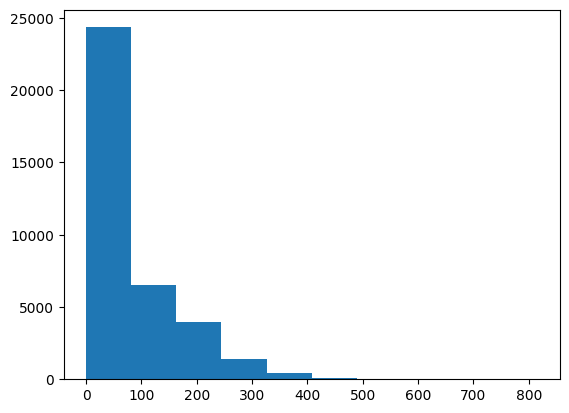

In [34]:
from matplotlib import pyplot as plt
plt.hist(lens)

In [37]:
sum(lens) / 128 / 32

591.42578125

In [32]:
np.mean(lens)

65.9752709842584

In [26]:
train_batch['input_ids']

tensor([[ 2061,   389,   262,  2482,    30,   198,   198, 21906,   198,    32,
          4812,   425,  2995,   347,  9865, 31688,    15,   389,  2995,   326,
          6032,  2689,   661,   287,  3967,   393,  4633,  2842,    13,  1114,
          1672,    11,  1972,  1637,   290,  2712,  5701,   389,  3221,  3967,
           284,   262,  3410,  7999,    26, 16508,  4692,   290,  6078,   530,
           338, 13008,   389,  4633,    13, 28491,  2689,   425,  2995,   318,
          1593,   284,  2972,  3288,  3303,  7587,   357,    45, 19930,     8,
          5479,   884,   355, 10721,  3341,   347,  9865, 31688,    16,    11,
          1808,    12,   504,    86,  1586,  3341,   347,  9865, 31688,    17,
            11,   290, 14733,  9465,   347,  9865, 31688,    18,    13,   554,
           428,  3348,    11,   356,   670,   319, 22650,   262,   755,  6806,
           286,   281,  2689,   425,  1785,   326,   318,  7997,   416,   257,
          4776, 12897,   422,   720,    12,    16,  

In [27]:
train_batch['input_ids_generate']

tensor([[ 2061,   389,   262,  2482,    30,   198,   198, 21906,   198,    32,
          4812,   425,  2995,   347,  9865, 31688,    15,   389,  2995,   326,
          6032,  2689,   661,   287,  3967,   393,  4633,  2842,    13,  1114,
          1672,    11,  1972,  1637,   290,  2712,  5701,   389,  3221,  3967,
           284,   262,  3410,  7999,    26, 16508,  4692,   290,  6078,   530,
           338, 13008,   389,  4633,    13, 28491,  2689,   425,  2995,   318,
          1593,   284,  2972,  3288,  3303,  7587,   357,    45, 19930,     8,
          5479,   884,   355, 10721,  3341,   347,  9865, 31688,    16,    11,
          1808,    12,   504,    86,  1586,  3341,   347,  9865, 31688,    17,
            11,   290, 14733,  9465,   347,  9865, 31688,    18,    13,   554,
           428,  3348,    11,   356,   670,   319, 22650,   262,   755,  6806,
           286,   281,  2689,   425,  1785,   326,   318,  7997,   416,   257,
          4776, 12897,   422,   720,    12,    16,  

In [28]:
tokenizer.batch_decode(train_batch['input_ids'])

["What are the results?\n\nIntroduction\nAffective events BIBREF0 are events that typically affect people in positive or negative ways. For example, getting money and playing sports are usually positive to the experiencers; catching cold and losing one's wallet are negative. Understanding affective events is important to various natural language processing (NLP) applications such as dialogue systems BIBREF1, question-answering systems BIBREF2, and humor recognition BIBREF3. In this paper, we work on recognizing the polarity of an affective event that is represented by a score ranging from $-1$[GEN]Using all data to train: AL -- BiGRU achieved 0.843 accuracy, AL -- BERT achieved 0.863 accuracy, AL+CA+CO -- BiGRU achieved 0.866 accuracy, AL+CA+CO -- BERT achieved 0.835, accuracy, ACP -- BiGRU achieved 0.919 accuracy, ACP -- BERT achived 0.933, accuracy, ACP+AL+CA+CO -- BiGRU achieved 0.917 accuracy, ACP+AL+CA+CO -- BERT achieved 0.913 accuracy. \nUsing",
 "How are relations used to propa

In [21]:
train_batch['labels_mask']

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

In [21]:
idx = train_batch.pop('id')
target_text = train_batch.pop('target_text')
input_ids_generate = train_batch.pop('input_ids_generate')
attention_mask_generate = train_batch.pop('attention_mask_generate')

out = model(**train_batch)
out.loss

tensor(86.1150, grad_fn=<NllLossBackward0>)

In [23]:
tokenizer.decode(train_batch['input_ids'][0])

"What is the seed lexicon?\n\nIntroduction\nAffective events BIBREF0 are events that typically affect people in positive or negative ways. For example, getting money and playing sports are usually positive to the experiencers; catching cold and losing one's wallet are negative. Understanding affective events is important to various natural language processing (NLP) applications such as dialogue systems BIBREF1, question-answering systems BIBREF2, and humor recognition BIBREF3. In this paper, we work on recognizing[GEN]a vocabulary of positive and negative predicates that helps determine the polarity score of an event"

In [24]:
train_dataset[0]

{'id': '753990d0b621d390ed58f20c4d9e4f065f0dc672',
 'pid': '753990d0b621d390ed58f20c4d9e4f065f0dc672_0',
 'input': 'What is the seed lexicon?\n\nIntroduction\nAffective events BIBREF0 are events that typically affect people in positive or negative ways. For example, getting money and playing sports are usually positive to the experiencers; catching cold and losing one\'s wallet are negative. Understanding affective events is important to various natural language processing (NLP) applications such as dialogue systems BIBREF1, question-answering systems BIBREF2, and humor recognition BIBREF3. In this paper, we work on recognizing the polarity of an affective event that is represented by a score ranging from $-1$ (negative) to 1 (positive).\nLearning affective events is challenging because, as the examples above suggest, the polarity of an event is not necessarily predictable from its constituent words. Combined with the unbounded combinatorial nature of language, the non-compositionality

In [36]:
keep_for_metrics_fn(train_batch, out)

{}

In [25]:
valid_gen=iter(train_dataloader)
valid_batch = next(valid_gen)
valid_batch.keys()

dict_keys(['input_ids', 'labels', 'input_ids_generate', 'labels_mask', 'attention_mask', 'id', 'target_text'])

In [26]:
input_ids = valid_batch['input_ids']

In [28]:
gen_out = model.generate(input_ids, attention_mask=valid_batch['attention_mask'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/jovyan/envs/accel_rmt/lib/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [30]:
gen_text = tokenizer.batch_decode(gen_out)
gen_text

['<|endoftext|>[GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN]',
 '<|endoftext|>[GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN][GEN]']

In [34]:
tokenizer.decode(train_batch['input_ids'][0])

"What is the seed lexicon?\n\nIntroduction\nAffective events BIBREF0 are events that typically affect people in positive or negative ways. For example, getting money and playing sports are usually positive to the experiencers; catching cold and losing one's wallet are negative. Understanding affective events is important to various natural language processing (NLP) applications such as dialogue systems BIBREF1, question-answering systems BIBREF2, and humor recognition BIBREF3. In this paper, we work on recognizing[GEN]a vocabulary of positive and negative predicates that helps determine the polarity score of an event"

In [40]:
data = dict(**valid_batch)
data['generation_outputs'] = gen_out

In [42]:
metrics_fn(data)

{'exact_match': 0.0, 'f1': 0.0}

In [41]:
keep_for_metrics_fn(valid_batch, gen_out)

RuntimeError: Tensor.__contains__ only supports Tensor or scalar, but you passed in a <class 'str'>.